# Missing Data

## Script Setup

In [1]:
# Third-party and standard modules
from typing import Dict, Hashable, Tuple, Union
from seaborn import heatmap
import pandas as pd
import matplotlib.pyplot as plt
import pytz
from importlib import reload

# User-defined modules.
from modules import dataframe_manip as dfm
from modules import misc, schemas, College1AcPtTimeSeries
# The reload() function is used to update modules after
# changes are made to their files.
dfm = reload(dfm)
misc = reload(misc)
schemas = reload(schemas)
College1AcPtTimeSeries = reload(College1AcPtTimeSeries)

## Script Parameters

In [2]:
filepath = './cisco_wifi_data_until_20190513.csv'
timezone = pytz.timezone('US/Pacific')
schema: schemas.AcPtTimeSeries =\
    College1AcPtTimeSeries.College1AcPtTimeSeries

## Preliminary Data Processing

In [3]:
occ: pd.DataFrame = dfm.csv_to_timeseries_df(
    filepath=filepath, timezone=timezone
)

## Missing Value Visualizations

In [4]:
def na_map_and_barchart(
    timeseries: pd.DataFrame, title: str, showcols: bool = False,
    xlabel: str = 'access points', ylabel: str = 'time',
    figsize: Tuple[Union[int, float], Union[int, float]] = (20, 20)
) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    timeseries_isna = timeseries.isna()
    ax.set_aspect(timeseries_isna.shape[1]/timeseries_isna.shape[0])
    heatmap(
        timeseries_isna, cbar=False, xticklabels=showcols, yticklabels=False
    )

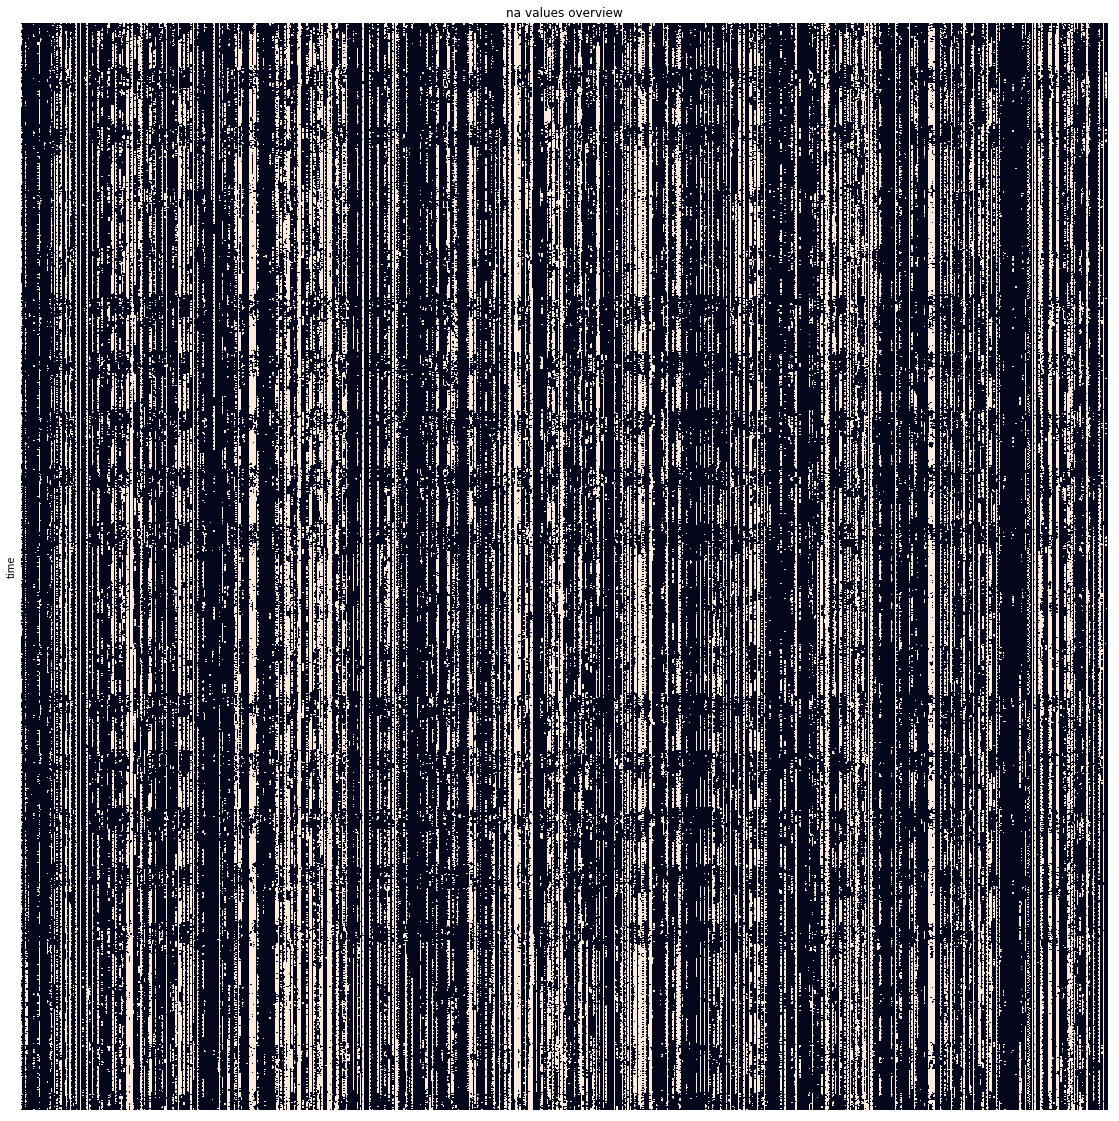

In [6]:
na_map_and_barchart(
    timeseries=occ, title='na values overview',
    showcols=False, figsize=(20, 20)
)